# Pendulum on chart

## Includes

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import sympy as sp
from scipy.integrate import odeint
from scipy.linalg import expm
from scipy.integrate import quad

from matplotlib import pyplot as plt
from matplotlib import animation as ani
from IPython.display import HTML

## Init symbols and funtions

In [2]:
# Physics
m, M, l, g = sp.symbols('m M l g')

t, Ts, Fb, gamma, beta = sp.symbols('t T_s Fb gamma beta' )
x = sp.Function('x')(t)
theta = sp.Function('theta')(t)
F = sp.Function('F')(t)

# Generalized coordinates
z1 = sp.Function('z1')(t)
z2 = sp.Function('z2')(t)
z3 = sp.Function('z3')(t)
z4 = sp.Function('z4')(t)
states = [z1,z2,z3,z4]
u  = sp.Function('u')(t)
inputs = [u]

## Penulum on chart equations

Position of cart and mass

In [3]:
xc = x
xm = x+l*sp.sin(theta)
ym = -l*sp.cos(theta)

Velocity of cart and mass

In [4]:
dxc = xc.diff(t)
dxm = xm.diff(t)
dym = ym.diff(t)

Acceleration of cart and mass

In [5]:
ddxc = dxc.diff(t)
ddxm = dxm.diff(t)
ddym = dym.diff(t)

Newtons law $\quad m \ddot{x}(t) = \sum_i F_i$

In [6]:
eqCx = -m*ddxc + F + Fb*sp.sin(theta)
eqMx = -M*ddxm - Fb*sp.sin(theta)
eqMy = -M*ddym + Fb*sp.cos(theta) - M*g

Eliminate $F_b$ and obtain two equations of motion

In [7]:
Fb_eqn = (eqMx/sp.sin(theta)+Fb).simplify()
EOM1 = eqCx.subs({Fb: Fb_eqn}).simplify()
EOM2 = (eqMx*sp.cos(theta)+eqMy*sp.sin(theta)).simplify()

In [8]:
EOM1

M*l*sin(theta(t))*Derivative(theta(t), t)**2 - M*l*cos(theta(t))*Derivative(theta(t), (t, 2)) - M*Derivative(x(t), (t, 2)) - m*Derivative(x(t), (t, 2)) + F(t)

In [9]:
EOM2

-M*(g*sin(theta(t)) + l*Derivative(theta(t), (t, 2)) + cos(theta(t))*Derivative(x(t), (t, 2)))

## Generalized coordinates

In [10]:
genCoords = {x:             z1, 
             x.diff(t):     z2, 
             theta:         z3, 
             theta.diff(t): z4, 
             F:              u}
sp.pprint(genCoords)

⎧                                      d                d              ⎫
⎨F(t): u(t), θ(t): z₃(t), x(t): z₁(t), ──(θ(t)): z₄(t), ──(x(t)): z₂(t)⎬
⎩                                      dt               dt             ⎭


### Substitute into equations

In [11]:
gEOM1 = EOM1.subs(genCoords)
gEOM1

M*l*z4(t)**2*sin(z3(t)) - M*l*cos(z3(t))*Derivative(z4(t), t) - M*Derivative(z2(t), t) - m*Derivative(z2(t), t) + u(t)

In [12]:
gEOM2 = EOM2.subs(genCoords)
gEOM2

-M*(g*sin(z3(t)) + l*Derivative(z4(t), t) + cos(z3(t))*Derivative(z2(t), t))

## Obtain the form $\dot{z}(t) = f(z)$

Solve EOM2 for $\dot{z}_2$ and $\dot{z}_4$, 

In [13]:
sol_dz4 = sp.solve(gEOM2,z4.diff(t))[0]
sol_dz4

-(g*sin(z3(t)) + cos(z3(t))*Derivative(z2(t), t))/l

In [14]:
sol_dz2 = sp.solve(gEOM2,z2.diff(t))[0]
sol_dz2

-g*tan(z3(t)) - l*Derivative(z4(t), t)/cos(z3(t))

Substitute $\dot{z}_2$ and $\dot{z}_4$ into EOM1

In [15]:
EQ_dz2 = gEOM1.subs({z4.diff(t):sol_dz4}).simplify()
EQ_dz2 = sp.solve(EQ_dz2,z2.diff(t))[0]
EQ_dz2

(M*g*sin(2*z3(t))/2 + M*l*z4(t)**2*sin(z3(t)) + u(t))/(M*sin(z3(t))**2 + m)

In [16]:
EQ_dz4 = gEOM1.subs({z2.diff(t):sol_dz2}).simplify()
EQ_dz4 = sp.solve(EQ_dz4,z4.diff(t))[0]
EQ_dz4

-(M*g*sin(z3(t)) + M*l*z4(t)**2*sin(2*z3(t))/2 + g*m*sin(z3(t)) + u(t)*cos(z3(t)))/(l*(M*sin(z3(t))**2 + m))

Get desired nonlinear vector valued function $f(z)$ such that $\dot{z} = f(z)$

In [17]:
f = []
f.append(z2)
f.append(EQ_dz2)
f.append(z4)
f.append(EQ_dz4)
f

[z2(t),
 (M*g*sin(2*z3(t))/2 + M*l*z4(t)**2*sin(z3(t)) + u(t))/(M*sin(z3(t))**2 + m),
 z4(t),
 -(M*g*sin(z3(t)) + M*l*z4(t)**2*sin(2*z3(t))/2 + g*m*sin(z3(t)) + u(t)*cos(z3(t)))/(l*(M*sin(z3(t))**2 + m))]

In [234]:
class NLDiffEQN:
    # List of state variables
    states = None
    nStates = 0
    # List of input variables
    inputs = None
    nInputs = 0
    # Equilibrium point
    eqPoint = None
    
    # Dict of constants in equations
    constants = None
    
    # List of symbolic nonlinear equations
    equationsNL = None
    nEquations = 0
    # List of symbolic nonlinear equations (constants substituted)
    equationsNLc = None
    
    # A and B matrix of linear, time-varying, continuous system
    Acltv = None
    Bcltv = None
    Acltvc = None
    Bcltvc = None
    
    # Constructor
    def __init__(self,equations,
                 states,inputs,
                 eqPoint,samplingTime,
                 constants = dict({})):
        self.Ts = samplingTime
        self.equationsNL = equations
        self.equationsNLc = [0]*len(equations)
        self.nEquations = len(equations)
        if len(constants) != 0:
            for i, e in enumerate(equations):
                self.equationsNLc[i] = e.subs(constants)
        self.states = states
        self.nStates = len(states)
        self.inputs = inputs
        self.nInputs = len(inputs)
        self.eqPoint = eqPoint
        self.constants = constants
        
        self.K = np.array([[4.0967,    6.7935,  -16.1388,   -3.2197]])
        self.K = np.array([[134.4222,   87.4114,  -51.8677,   65.4124]])
        # Compute continuous time, linear, time-varying system
        self.setLTI()
    
        
    def dfdtNL(self,zv,t,uv):
        res = [0]*len(zv)
        z = dict(zip(self.states,zv))
        u = dict(zip(self.inputs,-np.dot(self.K,np.array(zv).T)))
        for i, e in enumerate(self.equationsNLc):
            res[i] = e.subs(z).subs(u).evalf()
        return res
    
    def setLTI(self):
        nz = self.nStates
        nu = self.nInputs
        # Init A and B matrix
        A = [[0 for x in range(nz)] for y in range(nz)]
        B = [[0 for x in range(nu)] for y in range(nz)]
    
        # Linearize system
        for i, eq in enumerate(self.equationsNL):
            # Populate A matrix
            for j, z in enumerate(self.states):
                A[i][j] = eq.diff(z)
            # Populate B matrix
            for j, u in enumerate(self.inputs):
                B[i][j] = eq.diff(u).subs(self.constants)
        
        # continuous-time timeinvariant system
        self.A = sp.Matrix(A)
        self.B = sp.Matrix(B)
        self.Alti = sp.Matrix(A).subs(self.eqPoint)
        self.Blti = sp.Matrix(B).subs(self.eqPoint)
        self.Altic = sp.Matrix(A).subs(self.constants).subs(self.eqPoint)
        self.Bltic = sp.Matrix(B).subs(self.eqPoint).subs(self.constants)
        
        self.discretizeEulerFw();
        self.discretizeEulerBw();
        self.discretizeTustin();
        self.discretizeExact();
    
    def dfdtLTI(self,zv,t,uv):
        zd = dict(zip(self.states,zv))
        ud = dict(zip(self.inputs,uv))
        
        z = sp.Matrix(zv);
        u = sp.Matrix(uv);
        res = self.Altic*z + self.Bltic*u
        return list(res.evalf())
    
    def LTIdEulerFW(self,t,zv,uv):
        res = np.zeros((len(t),4))
        res[0,:] = zv
        for i in range(len(t)-1):
            res[i+1,:] = np.dot(self.AdEulerFw,res[i,:])+np.dot(self.BdEulerFw,uv)
        return res
    
    def LTIdEulerBW(self,t,zv,uv):
        res = np.zeros((len(t),4))
        res[0,:] = zv
        for i in range(len(t)-1):
            res[i+1,:] = np.dot(self.AdEulerBw,res[i,:])+np.dot(self.BdEulerBw,uv)
        return res
    
    def LTIdTustin(self,t,zv,uv):
        res = np.zeros((len(t),4))
        res[0,:] = zv
        for i in range(len(t)-1):
            res[i+1,:] = np.dot(self.AdTustin,res[i,:])+np.dot(self.BdTustin,uv)
        return res
    
    def discretizeEulerFw(self):
        self.AdEulerFw = np.identity(4)+np.array(self.Ts*self.Alti.subs(self.constants))
        self.BdEulerFw = np.array(self.Ts*self.Blti.subs(self.constants))
    
    def discretizeEulerBw(self):
        self.AdEulerBw = np.linalg.inv(np.identity(4)-np.array(self.Ts*self.Alti.subs(self.constants), dtype='float'))
        self.BdEulerBw = np.array(self.Ts*self.Blti.subs(self.constants))
        
    def discretizeTustin(self):
        AdTustin1 = (np.identity(4)+0.5*np.array(self.Ts*self.Alti.subs(self.constants), dtype='float'))
        AdTustin2 = (np.identity(4)-0.5*np.array(self.Ts*self.Alti.subs(self.constants), dtype='float'))
        self.AdTustin =np.dot(AdTustin1, np.linalg.inv(AdTustin2))
        self.BdTustin = np.array(self.Ts*self.Blti.subs(self.constants))
     
    def discretizeExact(self):
        self.AdExact = expm(np.array(self.Altic*self.Ts))
        P,J = self.Alti.jordan_form()
        expJ = sp.zeros(4,4)
        gam = (g*(M + m)/(l*m)).subs(self.constants)
        J1 = sp.Matrix([[1,t],[0,1]])
        J2 = sp.exp(-sp.sqrt(-gam)*t)
        J3 = sp.exp(sp.sqrt(-gam)*t)
        intJ1 = sp.integrate(J1,t)
        intJ2 = sp.integrate(J2,t)
        intJ3 = sp.integrate(J3,t)
        expJ[0:2,0:2] = intJ1.subs({t:Ts})-intJ1.subs({t:0})
        expJ[2,2] = intJ2.subs({t:Ts})-intJ2.subs({t:0})
        expJ[3,3] = intJ3.subs({t:Ts})-intJ3.subs({t:0})
        self.BdExact = np.array(sp.re((P*expJ*P.inv()).subs(self.constants).subs({Ts: self.Ts}))*self.Bltic,dtype='float')
        
    def LTIdExact(self,t,zv,uv):
        res = np.zeros((len(t),4))
        resLQR = np.zeros((len(t),4))
        uLQR = np.zeros((len(t-1),1))
        res[0,:] = zv
        resLQR[0,:] = zv
        for i in range(len(t)-1):
            res[i+1,:] = np.dot(self.AdExact,res[i,:])+np.dot(self.BdExact,uv)
            resLQR[i+1,:] = np.dot(self.AdExact,resLQR[i,:])-np.dot(np.dot(self.BdExact,self.K),resLQR[i])
            uLQR[i] = -np.dot(self.K,resLQR[i])
        return res, resLQR, uLQR

In [240]:
const = dict({M: 1,
              m: 1,
              g: 9.81,
              l: 1})
EQ_point = {z1: 0, z2: 0, z3: 0, z4: 0, u: 0}
z0 = [0,0,0.6,0]
u0 = [0]
Nt = 200
tmax = 5
tv = np.linspace(0, tmax, Nt)
Tsv = tv[1]-tv[0]

try: nldiff
except NameError:
    pass
else:
    del nldiff
nldiff = NLDiffEQN(f,[z1, z2, z3, z4],[u],EQ_point,Tsv,const)

In [241]:
resNL = odeint(nldiff.dfdtNL, z0, tv, args=(u0,))
resLTI = odeint(nldiff.dfdtLTI, z0, tv, args=(u0,))
resLTId_exact, resLTId_exact_lqr, resLTId_exact_u = nldiff.LTIdExact(tv,z0,u0)
resLTId_tustin = nldiff.LTIdTustin(tv,z0,u0)
resLTId_euler_bw = nldiff.LTIdEulerBW(tv,z0,u0)
resLTId_euler_fw = nldiff.LTIdEulerFW(tv,z0,u0)
res = [resNL, resLTI, resLTId_exact_lqr, resLTId_tustin, resLTId_euler_bw, resLTId_euler_fw]

In [196]:
def drawCartPendulum(i, data, col, ax):
    # Chart position
    xc = data[i,0]
    yc = 0
    p = ax1.scatter(xc,yc,s=40,c=col)
    
    # Position of mass
    theta = data[i,2]
    xm = xc+np.sin(theta)
    ym = -np.cos(theta)
    ax1.scatter(xm,ym,s=150,c=col)
    
    # Draw line
    ax1.plot([xc,xm],[yc,ym],c=col)

def plotCartPosition(t, data, col, ax):
    xc = data[:,0]
    ax.plot(t, xc,c=col)

def plotBarAngle(t, data, col, ax):
    xc = data[:,2]
    ax.plot(t, xc,c=col)
    
def animatePlot(i,data):
    colors = ['k','b','r','g','m','y']
    ax1.clear()
    for k, d in enumerate(data):
        drawCartPendulum(i, d, colors[k] , ax1)
    ax1.legend(("$Nonlinear^{(c)}$","$LTI^{(c)}$",'$LTI^{(d)}_{Exact}$',"$LTI^{(d)}_{Tustin}$","$LTI^{(d)}_{EulerBW}$","$LTI^{(d)}_{EulerFW}$"))
    plt.xlim(-0.5, 1.5)
    plt.ylim(-1*const[l],0.05)

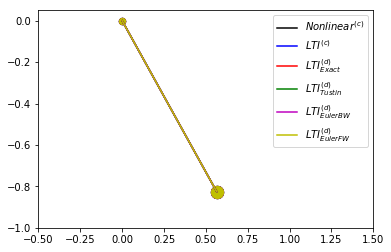

In [243]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1, 1, 1)
an = ani.FuncAnimation(fig1, animatePlot, frames=len(res[0]),fargs=(res, ), interval=tmax/Nt*1000, repeat=False)
HTML(an.to_html5_video())

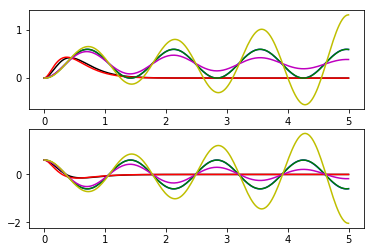

In [242]:
fig2, (ax1,ax2) = plt.subplots(2,1)
for i, r in enumerate(res):
    colors = ['k','b','r','g','m','y']
    plotCartPosition(tv,r,colors[i],ax1)
    plotBarAngle(tv,r,colors[i],ax2)